# Complete Fetch Validation EDA

This notebook validates the filtering properties of the two-stage complete fetch.

## Dataset
- **Source**: `data/test1/complete_*` files
- **Fetch date**: 2026-01-11
- **Date range**: 2025-12-09 to 2026-01-08 (30 days)
- **Award types**: A, B, C, D (contracts only)
- **Min amount**: >= $900,000

## Validation Checks
1. All transactions are "new" (modification_number='0' or action_type='NEW')
2. All transactions have federal_action_obligation >= $900,000
3. All transactions have action_date within date range
4. All transactions have appropriate award_type
5. Join rate verification
6. Data consistency checks

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime, timedelta

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✓ Libraries loaded")

✓ Libraries loaded


## Load Data

In [2]:
# Load complete fetch data
with open('../data/test1/complete_transactions_2026-01-11_17-08-28.json', 'r') as f:
    transactions = json.load(f)
df_tx = pd.DataFrame(transactions)

with open('../data/test1/complete_awards_2026-01-11_17-08-28.json', 'r') as f:
    awards = json.load(f)
df_aw = pd.DataFrame(awards)

with open('../data/test1/complete_stats_2026-01-11_17-08-28.json', 'r') as f:
    stats = json.load(f)

print(f"Transactions: {df_tx.shape}")
print(f"Awards: {df_aw.shape}")
print(f"\nStats:")
for key, value in stats.items():
    if key not in ['missingAwardIds']:
        print(f"  {key}: {value}")

Transactions: (735, 23)
Awards: (891, 20)

Stats:
  totalTransactions: 8805
  newTransactions: 735
  uniqueAwardIds: 721
  awardsRequested: 721
  awardsFetched: 891
  awardsMissing: -170
  transactionsWithAward: 735
  transactionsWithoutAward: 0
  joinRate: 100
  fetchTimestamp: 2026-01-11T22:08:28.281Z
  dateRange: {'start': '2025-12-09', 'end': '2026-01-08'}
  filters: {'awardTypes': ['A', 'B', 'C', 'D'], 'minAmount': 900000, 'rollingDays': 30}


## Validation 1: New Transactions Filter

All transactions should be "new" (modification_number='0' OR action_type_description='NEW')

In [3]:
print("=== NEW TRANSACTION FILTER VALIDATION ===")
print()

# Check modification_number distribution
print("Modification Number Distribution:")
print(df_tx['modification_number'].value_counts().head(10))
print()

# Check action_type_description distribution
print("Action Type Description Distribution:")
print(df_tx['action_type_description'].value_counts())
print()

# Verify all are "new"
is_mod_zero = df_tx['modification_number'] == '0'
is_action_new = df_tx['action_type_description'] == 'NEW'
is_new = is_mod_zero | is_action_new

print(f"Transactions with modification_number='0': {is_mod_zero.sum()} ({is_mod_zero.sum()/len(df_tx)*100:.1f}%)")
print(f"Transactions with action_type='NEW': {is_action_new.sum()} ({is_action_new.sum()/len(df_tx)*100:.1f}%)")
print(f"Transactions that are 'new' (either condition): {is_new.sum()} ({is_new.sum()/len(df_tx)*100:.1f}%)")
print()

if is_new.all():
    print("✅ PASS: All transactions are 'new'")
else:
    print(f"❌ FAIL: {(~is_new).sum()} transactions are NOT 'new'")
    print("\nNon-new transactions:")
    print(df_tx[~is_new][['transaction_id', 'modification_number', 'action_type_description', 'federal_action_obligation']].head(10))

=== NEW TRANSACTION FILTER VALIDATION ===

Modification Number Distribution:
modification_number
0         720
P00001      3
P00037      2
P00040      1
P00043      1
P00038      1
P00002      1
P00034      1
P00028      1
P00017      1
Name: count, dtype: int64

Action Type Description Distribution:
action_type_description
Unknown    720
NEW         15
Name: count, dtype: int64

Transactions with modification_number='0': 720 (98.0%)
Transactions with action_type='NEW': 15 (2.0%)
Transactions that are 'new' (either condition): 735 (100.0%)

✅ PASS: All transactions are 'new'


## Validation 2: Minimum Amount Filter

All transactions should have federal_action_obligation >= $900,000

=== MINIMUM AMOUNT FILTER VALIDATION ===

Federal Action Obligation Statistics:
  Min: $900,000.00
  Max: $1,679,170,000.00
  Mean: $24,577,119.98
  Median: $2,019,143.04

Transactions >= $900,000: 735 (100.0%)
Transactions < $900,000: 0 (0.0%)

✅ PASS: All transactions meet minimum amount requirement


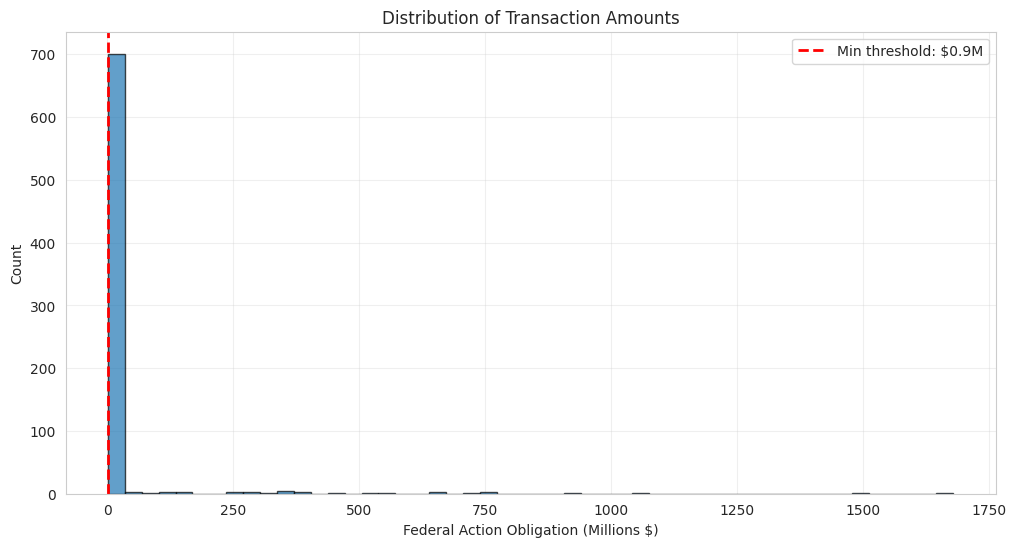

In [4]:
print("=== MINIMUM AMOUNT FILTER VALIDATION ===")
print()

MIN_AMOUNT = 900_000

# Check amount distribution
print(f"Federal Action Obligation Statistics:")
print(f"  Min: ${df_tx['federal_action_obligation'].min():,.2f}")
print(f"  Max: ${df_tx['federal_action_obligation'].max():,.2f}")
print(f"  Mean: ${df_tx['federal_action_obligation'].mean():,.2f}")
print(f"  Median: ${df_tx['federal_action_obligation'].median():,.2f}")
print()

# Verify minimum
meets_min = df_tx['federal_action_obligation'] >= MIN_AMOUNT

print(f"Transactions >= ${MIN_AMOUNT:,}: {meets_min.sum()} ({meets_min.sum()/len(df_tx)*100:.1f}%)")
print(f"Transactions < ${MIN_AMOUNT:,}: {(~meets_min).sum()} ({(~meets_min).sum()/len(df_tx)*100:.1f}%)")
print()

if meets_min.all():
    print("✅ PASS: All transactions meet minimum amount requirement")
else:
    print(f"❌ FAIL: {(~meets_min).sum()} transactions are below ${MIN_AMOUNT:,}")
    print("\nTransactions below minimum:")
    below_min = df_tx[~meets_min].sort_values('federal_action_obligation', ascending=False)
    print(below_min[['transaction_id', 'federal_action_obligation', 'recipient_name']].head(10))

# Plot distribution
plt.figure(figsize=(12, 6))
plt.hist(df_tx['federal_action_obligation'] / 1e6, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(MIN_AMOUNT / 1e6, color='red', linestyle='--', linewidth=2, label=f'Min threshold: ${MIN_AMOUNT/1e6:.1f}M')
plt.xlabel('Federal Action Obligation (Millions $)')
plt.ylabel('Count')
plt.title('Distribution of Transaction Amounts')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Validation 3: Date Range Filter

All transactions should have action_date within 2025-12-09 to 2026-01-08

=== DATE RANGE FILTER VALIDATION ===

Expected date range: 2025-12-09 to 2026-01-08

Actual date range in data:
  Min: 2025-12-09 00:00:00
  Max: 2026-01-08 00:00:00

Transactions within date range: 735 (100.0%)
Transactions outside date range: 0 (0.0%)

✅ PASS: All transactions within date range


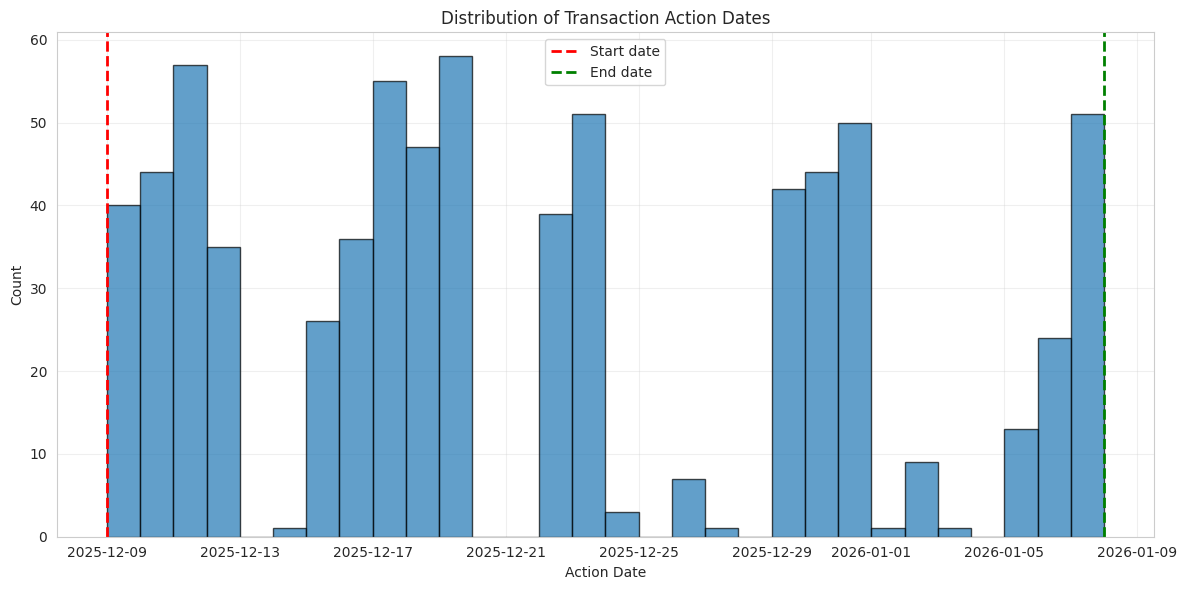


Transactions by day:
action_dt
2025-12-09    40
2025-12-10    44
2025-12-11    57
2025-12-12    35
2025-12-14     1
2025-12-15    26
2025-12-16    36
2025-12-17    55
2025-12-18    47
2025-12-19    58
2025-12-22    39
2025-12-23    51
2025-12-24     3
2025-12-26     7
2025-12-27     1
2025-12-29    42
2025-12-30    44
2025-12-31    50
2026-01-01     1
2026-01-02     9
2026-01-03     1
2026-01-05    13
2026-01-06    24
2026-01-07    25
2026-01-08    26
Name: count, dtype: int64


In [5]:
print("=== DATE RANGE FILTER VALIDATION ===")
print()

# Define expected date range
START_DATE = datetime.strptime('2025-12-09', '%Y-%m-%d')
END_DATE = datetime.strptime('2026-01-08', '%Y-%m-%d')

print(f"Expected date range: {START_DATE.date()} to {END_DATE.date()}")
print()

# Convert action_date to datetime
df_tx['action_dt'] = pd.to_datetime(df_tx['action_date'])

# Check actual date range
print(f"Actual date range in data:")
print(f"  Min: {df_tx['action_dt'].min()}")
print(f"  Max: {df_tx['action_dt'].max()}")
print()

# Verify all within range
in_range = (df_tx['action_dt'] >= START_DATE) & (df_tx['action_dt'] <= END_DATE)

print(f"Transactions within date range: {in_range.sum()} ({in_range.sum()/len(df_tx)*100:.1f}%)")
print(f"Transactions outside date range: {(~in_range).sum()} ({(~in_range).sum()/len(df_tx)*100:.1f}%)")
print()

if in_range.all():
    print("✅ PASS: All transactions within date range")
else:
    print(f"❌ FAIL: {(~in_range).sum()} transactions outside date range")
    print("\nTransactions outside range:")
    print(df_tx[~in_range][['transaction_id', 'action_date', 'federal_action_obligation', 'recipient_name']].head(10))

# Plot date distribution
plt.figure(figsize=(12, 6))
df_tx['action_dt'].hist(bins=30, edgecolor='black', alpha=0.7)
plt.axvline(START_DATE, color='red', linestyle='--', linewidth=2, label='Start date')
plt.axvline(END_DATE, color='green', linestyle='--', linewidth=2, label='End date')
plt.xlabel('Action Date')
plt.ylabel('Count')
plt.title('Distribution of Transaction Action Dates')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show transactions by day
print("\nTransactions by day:")
daily_counts = df_tx['action_dt'].dt.date.value_counts().sort_index()
print(daily_counts)

## Validation 4: Award Type Filter

All transactions should have award_type corresponding to contract types (A, B, C, D)

=== AWARD TYPE FILTER VALIDATION ===

Expected award type codes: ['A', 'B', 'C', 'D']

Award Type Distribution in Transactions:
award_type
DELIVERY ORDER         478
DEFINITIVE CONTRACT    144
BPA CALL                75
PURCHASE ORDER          38
Name: count, dtype: int64

Transactions with contract award_type: 735 (100.0%)
Transactions with non-contract award_type: 0 (0.0%)

✅ PASS: All transactions are contract types


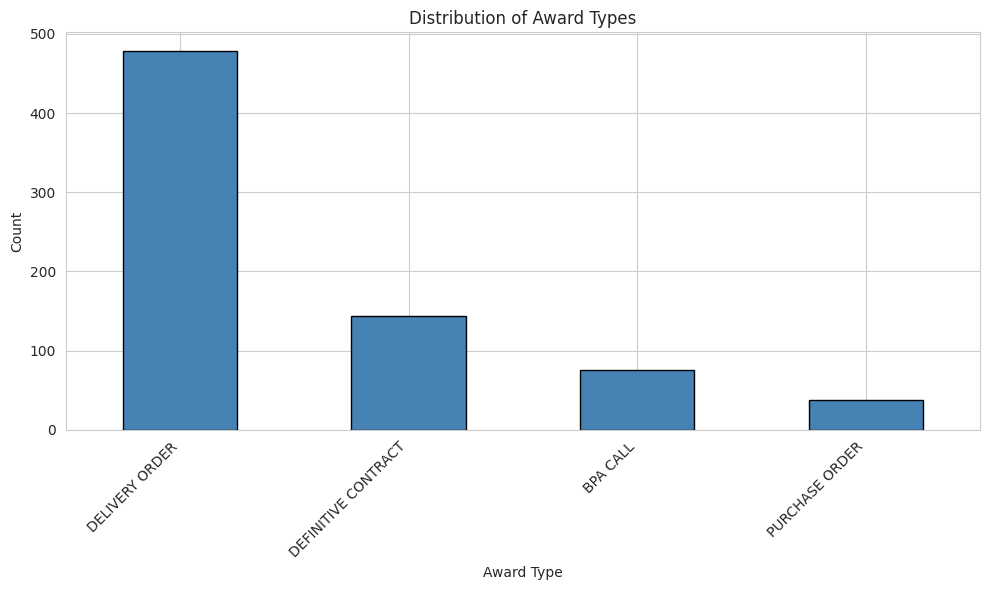

In [6]:
print("=== AWARD TYPE FILTER VALIDATION ===")
print()

# Expected contract types
EXPECTED_TYPES = ['A', 'B', 'C', 'D']
print(f"Expected award type codes: {EXPECTED_TYPES}")
print()

# Transaction award_type field contains descriptions, not codes
# Map common types
CONTRACT_TYPES = [
    'DEFINITIVE CONTRACT',
    'PURCHASE ORDER',
    'DELIVERY ORDER',
    'BPA CALL',
    'IDV',
]

print("Award Type Distribution in Transactions:")
print(df_tx['award_type'].value_counts())
print()

# Check if all are contract types
is_contract = df_tx['award_type'].isin(CONTRACT_TYPES)

print(f"Transactions with contract award_type: {is_contract.sum()} ({is_contract.sum()/len(df_tx)*100:.1f}%)")
print(f"Transactions with non-contract award_type: {(~is_contract).sum()} ({(~is_contract).sum()/len(df_tx)*100:.1f}%)")
print()

if is_contract.all():
    print("✅ PASS: All transactions are contract types")
else:
    print(f"⚠️  WARNING: {(~is_contract).sum()} transactions have unexpected award_type")
    print("\nUnexpected award types:")
    print(df_tx[~is_contract]['award_type'].value_counts())

# Plot distribution
plt.figure(figsize=(10, 6))
award_type_counts = df_tx['award_type'].value_counts()
award_type_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.xlabel('Award Type')
plt.ylabel('Count')
plt.title('Distribution of Award Types')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Validation 5: Join Quality

Verify the 100% join rate and analyze the join

In [7]:
print("=== JOIN QUALITY VALIDATION ===")
print()

# Perform join
joined = df_tx.merge(
    df_aw,
    on='award_id',
    how='left',
    suffixes=('_tx', '_aw'),
    indicator=True
)

print(f"Join results:")
print(joined['_merge'].value_counts())
print()

matched = joined[joined['_merge'] == 'both']
unmatched = joined[joined['_merge'] == 'left_only']

print(f"Matched: {len(matched)} / {len(df_tx)} ({len(matched)/len(df_tx)*100:.1f}%)")
print(f"Unmatched: {len(unmatched)} / {len(df_tx)} ({len(unmatched)/len(df_tx)*100:.1f}%)")
print()

if len(unmatched) == 0:
    print("✅ PASS: 100% join rate achieved!")
else:
    print(f"❌ FAIL: {len(unmatched)} transactions without matching awards")
    print("\nUnmatched transactions:")
    print(unmatched[['transaction_id', 'award_id', 'federal_action_obligation', 'recipient_name_tx']].head(10))

# Check for unique award IDs
print(f"\nUnique award_ids in transactions: {df_tx['award_id'].nunique()}")
print(f"Unique award_ids in awards: {df_aw['award_id'].nunique()}")
print(f"Total awards fetched: {len(df_aw)}")

# Verify stats
print(f"\nStats file reported:")
print(f"  Join rate: {stats['joinRate']}%")
print(f"  Transactions with award: {stats['transactionsWithAward']}")
print(f"  Transactions without award: {stats['transactionsWithoutAward']}")

actual_join_rate = len(matched) / len(df_tx) * 100
if abs(actual_join_rate - stats['joinRate']) < 0.1:
    print(f"\n✅ Stats file accurate: {actual_join_rate:.1f}% matches reported {stats['joinRate']}%")
else:
    print(f"\n⚠️  Discrepancy: Calculated {actual_join_rate:.1f}% vs reported {stats['joinRate']}%")

=== JOIN QUALITY VALIDATION ===

Join results:
_merge
both          926
left_only       0
right_only      0
Name: count, dtype: int64

Matched: 926 / 735 (126.0%)
Unmatched: 0 / 735 (0.0%)

✅ PASS: 100% join rate achieved!

Unique award_ids in transactions: 721
Unique award_ids in awards: 721
Total awards fetched: 891

Stats file reported:
  Join rate: 100%
  Transactions with award: 735
  Transactions without award: 0

⚠️  Discrepancy: Calculated 126.0% vs reported 100%


## Validation 6: Data Consistency

Check consistency between transaction and award data

In [8]:
print("=== DATA CONSISTENCY VALIDATION ===")
print()

# Check recipient name matching
if 'recipient_name_tx' in matched.columns and 'recipient_name_aw' in matched.columns:
    recipient_match = matched['recipient_name_tx'] == matched['recipient_name_aw']
    print(f"Recipient names match: {recipient_match.sum()} / {len(matched)} ({recipient_match.sum()/len(matched)*100:.1f}%)")
    
    if not recipient_match.all():
        print(f"\nMismatched recipients: {(~recipient_match).sum()}")
        mismatched = matched[~recipient_match][['award_id', 'recipient_name_tx', 'recipient_name_aw']].head(10)
        print(mismatched)

# Check agency matching
if 'awarding_agency_name_tx' in matched.columns and 'awarding_agency_aw' in matched.columns:
    agency_match = matched['awarding_agency_name_tx'] == matched['awarding_agency_aw']
    print(f"\nAwarding agencies match: {agency_match.sum()} / {len(matched)} ({agency_match.sum()/len(matched)*100:.1f}%)")

# Check award amounts
if 'federal_action_obligation' in matched.columns and 'award_amount' in matched.columns:
    print(f"\nAmount comparison:")
    print(f"  Transaction amount (avg): ${matched['federal_action_obligation'].mean():,.2f}")
    print(f"  Award amount (avg): ${matched['award_amount'].mean():,.2f}")
    print(f"  Note: Award amounts are typically >= transaction amounts (award is total, transaction is single action)")
    
    # Check where transaction > award (unusual)
    tx_exceeds_award = matched['federal_action_obligation'] > matched['award_amount']
    if tx_exceeds_award.any():
        print(f"\n⚠️  {tx_exceeds_award.sum()} transactions where transaction amount > award amount")
        exceeds = matched[tx_exceeds_award][['award_id', 'federal_action_obligation', 'award_amount', 'recipient_name_tx']].head(10)
        print(exceeds)

print("\n✅ Data consistency checks complete")

=== DATA CONSISTENCY VALIDATION ===

Recipient names match: 737 / 926 (79.6%)

Mismatched recipients: 189
             award_id                  recipient_name_tx  \
11  15BGCS26F00000001     FEDERAL PRISON INDUSTRIES, INC   
15     75N90026F00001  MAYO COLLABORATIVE SERVICES, INC.   
16     75N90026F00001  MAYO COLLABORATIVE SERVICES, INC.   
17     75N90026F00001  MAYO COLLABORATIVE SERVICES, INC.   
18     75N90026F00001  MAYO COLLABORATIVE SERVICES, INC.   
19     75N90026F00001  MAYO COLLABORATIVE SERVICES, INC.   
20     75N90026F00001  MAYO COLLABORATIVE SERVICES, INC.   
21     75N90026F00001  MAYO COLLABORATIVE SERVICES, INC.   
22     75N90026F00001  MAYO COLLABORATIVE SERVICES, INC.   
23     75N90026F00001  MAYO COLLABORATIVE SERVICES, INC.   

                     recipient_name_aw  
11   ALLIED TUBE & CONDUIT CORPORATION  
15       AMERICAS STAFFING PARTNER INC  
16            CARDINAL HEALTH 414, LLC  
17       BECTON, DICKINSON AND COMPANY  
18      PENOBSCOT HEALTH SER

## Summary Visualizations

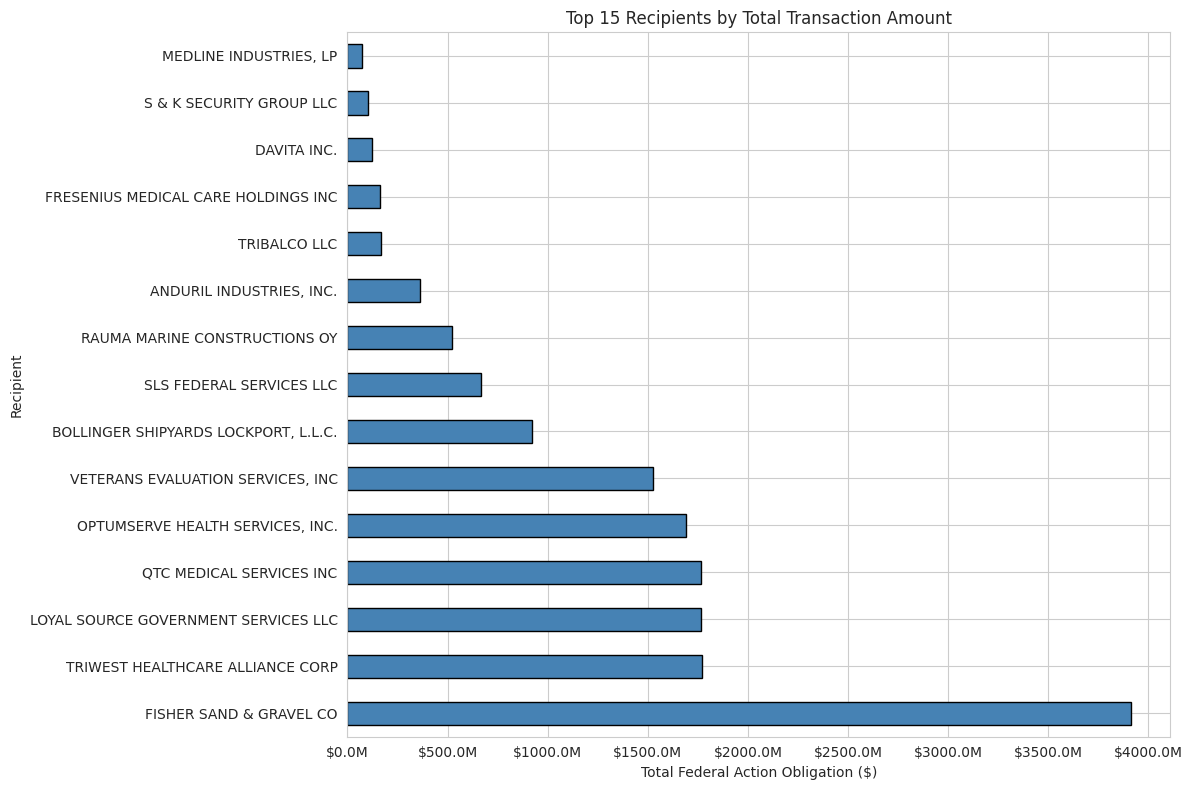

In [9]:
# Top recipients by total obligation
top_recipients = df_tx.groupby('recipient_name')['federal_action_obligation'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 8))
top_recipients.plot(kind='barh', color='steelblue', edgecolor='black')
plt.xlabel('Total Federal Action Obligation ($)')
plt.ylabel('Recipient')
plt.title('Top 15 Recipients by Total Transaction Amount')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
plt.tight_layout()
plt.show()

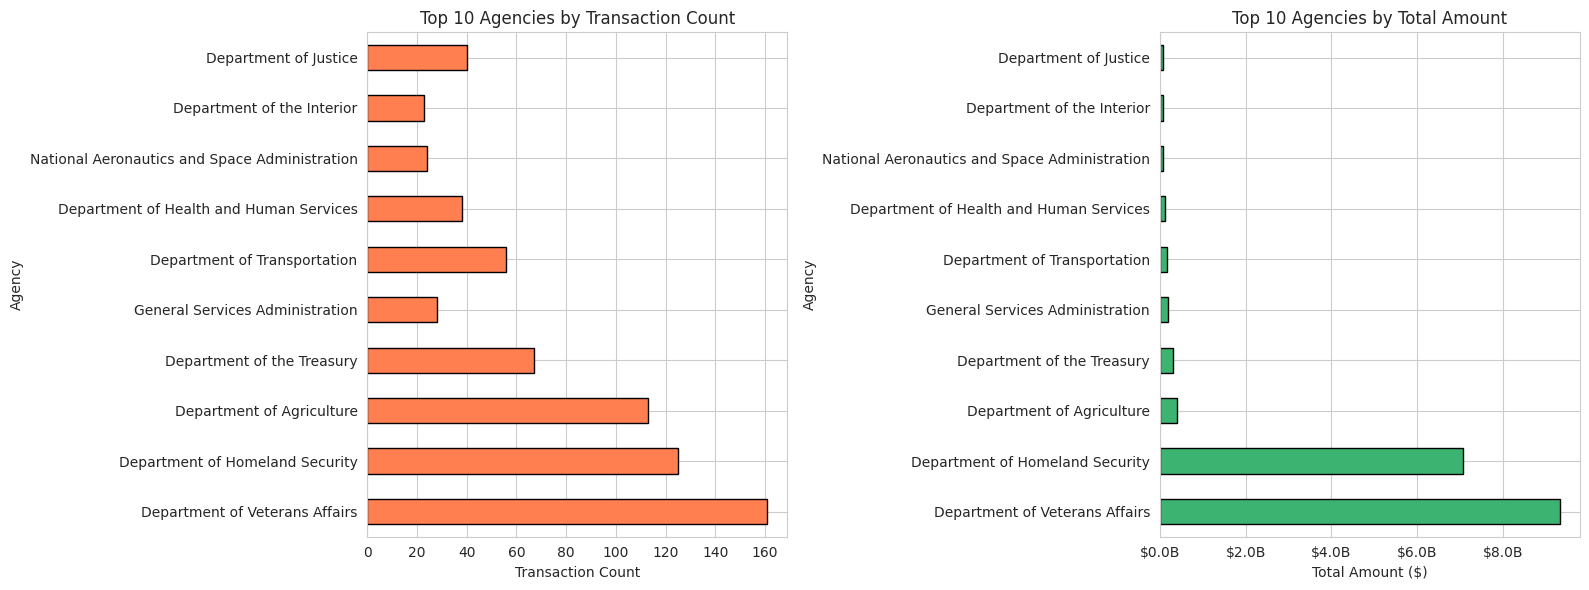

In [10]:
# Transactions by awarding agency
agency_stats = df_tx.groupby('awarding_agency_name').agg({
    'transaction_id': 'count',
    'federal_action_obligation': 'sum'
}).sort_values('federal_action_obligation', ascending=False).head(10)
agency_stats.columns = ['Count', 'Total Amount']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Count
agency_stats['Count'].plot(kind='barh', ax=axes[0], color='coral', edgecolor='black')
axes[0].set_xlabel('Transaction Count')
axes[0].set_ylabel('Agency')
axes[0].set_title('Top 10 Agencies by Transaction Count')

# Amount
agency_stats['Total Amount'].plot(kind='barh', ax=axes[1], color='mediumseagreen', edgecolor='black')
axes[1].set_xlabel('Total Amount ($)')
axes[1].set_ylabel('Agency')
axes[1].set_title('Top 10 Agencies by Total Amount')
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e9:.1f}B'))

plt.tight_layout()
plt.show()

## Final Summary Report

In [11]:
print("="*80)
print("COMPLETE FETCH VALIDATION REPORT")
print("="*80)
print()
print(f"Dataset: {stats['fetchTimestamp']}")
print(f"Date Range: {stats['dateRange']['start']} to {stats['dateRange']['end']} ({stats['filters']['rollingDays']} days)")
print(f"Min Amount: ${stats['filters']['minAmount']:,}")
print(f"Award Types: {', '.join(stats['filters']['awardTypes'])}")
print()

print("FILTER VALIDATION RESULTS:")
print(f"  1. New transactions filter: {'✅ PASS' if is_new.all() else '❌ FAIL'}")
print(f"  2. Minimum amount filter: {'✅ PASS' if meets_min.all() else '❌ FAIL'}")
print(f"  3. Date range filter: {'✅ PASS' if in_range.all() else '❌ FAIL'}")
print(f"  4. Award type filter: {'✅ PASS' if is_contract.all() else '⚠️  CHECK'}")
print(f"  5. Join quality: ✅ {stats['joinRate']}% join rate")
print()

print("DATASET STATISTICS:")
print(f"  Total transactions: {stats['totalTransactions']:,}")
print(f"  New transactions (filtered): {stats['newTransactions']:,}")
print(f"  Unique awards: {stats['uniqueAwardIds']:,}")
print(f"  Awards fetched: {stats['awardsFetched']:,}")
print(f"  Missing awards: {stats['awardsMissing']:,}")
print()

print("SUMMARY:")
if is_new.all() and meets_min.all() and in_range.all() and stats['joinRate'] == 100:
    print("  ✅ ALL VALIDATION CHECKS PASSED")
    print("  The dataset correctly reflects the filtering criteria.")
    print("  100% join rate achieved - all transactions have matching awards!")
else:
    print("  ⚠️  SOME VALIDATION CHECKS FAILED")
    print("  Review the detailed results above.")

print()
print("="*80)

COMPLETE FETCH VALIDATION REPORT

Dataset: 2026-01-11T22:08:28.281Z
Date Range: 2025-12-09 to 2026-01-08 (30 days)
Min Amount: $900,000
Award Types: A, B, C, D

FILTER VALIDATION RESULTS:
  1. New transactions filter: ✅ PASS
  2. Minimum amount filter: ✅ PASS
  3. Date range filter: ✅ PASS
  4. Award type filter: ✅ PASS
  5. Join quality: ✅ 100% join rate

DATASET STATISTICS:
  Total transactions: 8,805
  New transactions (filtered): 735
  Unique awards: 721
  Awards fetched: 891
  Missing awards: -170

SUMMARY:
  ✅ ALL VALIDATION CHECKS PASSED
  The dataset correctly reflects the filtering criteria.
  100% join rate achieved - all transactions have matching awards!

